# Combining Sentiment Analysis and Identifying Keywords With Topics

The <b> purpose</b> of this notebook is to combine sentiment analysis from prior notebooks and identify keywords from text and titles. The <b> results</b> will be inputted into the Twitter API search feature, but we need to be able to create specific topics to do so. 

## Libraries

In [43]:
import pandas as pd
import numpy as np
from pprint import pprint
import datetime
import spacy
import re
import json
import os
import matplotlib.pyplot as plt
import matplotlib
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import models
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
import pyLDAvis.gensim
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/celinasprague/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Datasets From Prior Notebook

In [62]:
data = pd.read_csv('webhosedata.csv', dtype = str)

In [64]:
data_colnan=data.columns[data.isnull().any()]
data[data_colnan].isnull().sum()

Author                                 30
Title                                  17
External Links                         47
Mentioned Persons (positive)           99
Mentioned Persons (negative)           94
Mentioned Persons (neutral)            97
Mentioned Persons (none)               54
Mentioned Locations                    63
Mentioned Organizations (positive)    100
Mentioned Organizations (negative)     86
Mentioned Organizations (neutral)      97
Mentioned Organizations (none)         39
Section Link                            6
Section Title                           6
Main Image                             23
Rating                                100
dtype: int64

In [47]:
data['title'] = data['title'].fillna("none")
data['text'] = data['text'].fillna("none")

## Setting Up NLP Helper Functions

In [65]:
data = data.Text.values.tolist()

In [66]:
def sent_to_words(sentences):
    
    counter = 0
    start_time = time.time()
    
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        counter += 1
        
        if counter % 10000 == 0:
            print("There have been {} files read so far".format(counter))
            print("Time elapsed: {}".format(time.time() - start_time))
        
    
    print("Operation complete after {} seconds.".format(time.time()-start_time))   

data_words = list(sent_to_words(data))


Operation complete after 0.27953195571899414 seconds.


In [67]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    counter = 0
    start_time = time.time()
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        
        counter += 1
        if counter % 10000 == 0:
            print("There have been {} files read so far".format(counter))
            print("Time elapsed: {}".format(time.time() - start_time))
        
    
    print("Operation complete after {} seconds.".format(time.time()-start_time))   

     

    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


Operation complete after 4.158673048019409 seconds.


In [68]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [70]:
# Build LDA Model

lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

In [76]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [78]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))


# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -64769.89251237934
Perplexity:  195.1097709231798
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [72]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()


# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -23167.013302618605
Model Perplexity:  153.25556323568588


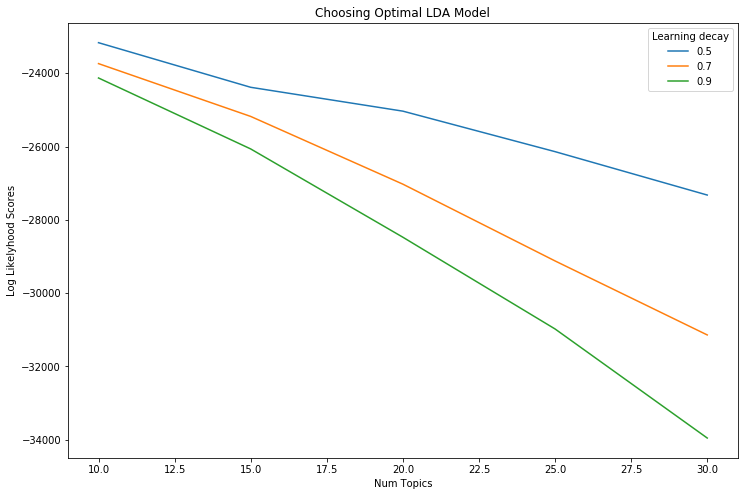

In [80]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [82]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic0", "Topic1", "Topic2", "Topic3", "Topic4", "Topic5", "Topic6", "Topic7", "Topic8", "Topic9"]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)

In [83]:
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0,0,0,0.05,0,0.94,0,0,7
Doc1,0,0,0,0,0,0.05,0,0.95,0,0,7
Doc2,0,0,0,0,0.99,0,0,0,0,0,4
Doc3,0,0.24,0,0,0,0,0,0.75,0,0,7
Doc4,0,0,0,0,0.4,0,0.23,0,0,0.36,4
Doc5,0,0,0,0,0.99,0,0,0,0,0,4
Doc6,0,0,0,0,0,0.11,0,0.89,0,0,7
Doc7,0,0,0,0,0,0.03,0,0.97,0,0,7
Doc8,0,0,0,0,0,1,0,0,0,0,5
Doc9,0.02,0.02,0.02,0.02,0.57,0.02,0.02,0.02,0.02,0.27,4


In [84]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.to_csv("train_topic_distribution.csv")

In [86]:
df_topic_distribution

,Topic Num,Num Documents
0,7,28
1,4,25
2,0,13
3,3,9
4,6,8
5,9,7
6,1,6
7,5,2
8,8,1
9,2,1


In [87]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.to_csv("ropic_keywords.csv")

In [88]:
df_topic_keywords

,access,accord,acquire,activity,add,addition,additional,address,alert,america,...,warn,website,wednesday,work,world,worth,www,year,yield,zack
Topic0,0.617821,0.148355,0.165224,0.184062,0.185242,1.556226,0.155962,0.142154,0.536259,0.204874,...,0.179352,2.456669,2.099670,0.160000,0.247037,0.153506,6.066904,3.528520,0.765182,0.167591
Topic1,0.311757,4.705592,0.265041,4.786232,0.154245,7.752224,0.327496,2.532731,0.320777,4.075487,...,0.189033,4.577923,1.203229,3.198791,24.143014,0.263927,11.057908,4.385428,0.166037,0.159466
Topic2,0.147483,0.159929,0.151152,0.177952,0.141992,0.153708,0.148696,0.143438,0.158996,0.150140,...,0.155064,0.161039,0.162424,0.145005,0.148688,0.152664,0.177188,0.228324,0.149085,0.150431
Topic3,0.144752,0.149854,0.146965,0.142769,0.145159,0.157076,0.147976,0.144936,0.137066,0.136122,...,0.140129,0.164302,0.147255,0.297526,2.048306,0.160940,0.157248,0.146643,0.155652,0.147696
Topic4,1.097138,3.788563,0.261695,2.021964,9.269870,4.709128,1.942152,9.450936,0.154551,4.997960,...,1.102616,2.059396,3.034905,37.256345,8.784906,1.075234,2.999978,42.204279,0.141989,0.141377
Topic5,2.435146,2.078559,6.715970,20.696886,0.209135,0.301370,6.457309,2.533482,1.771940,1.734814,...,1.637526,2.154161,2.500175,1.827316,0.902621,3.803152,4.314579,192.229003,2.358880,2.040976
Topic6,0.157167,0.152028,0.143930,0.141136,1.188247,4.223551,0.146122,0.179884,0.143071,13.411939,...,0.141421,7.092966,1.073104,1.365797,0.370367,0.148504,0.167607,2.477412,0.149405,0.148707
Topic7,13.567448,10.854320,39.627889,3.544643,0.163877,0.199318,42.851210,3.094632,21.597151,8.667542,...,11.803024,9.769897,24.680696,0.171887,0.223963,43.542168,18.689456,21.771707,10.515609,13.352019
Topic8,0.158518,1.107708,0.204455,1.089663,2.992181,0.156546,1.255726,0.160390,0.192671,0.157949,...,0.203114,0.192422,0.179876,0.151014,2.939847,0.308059,1.112153,0.243134,0.176446,0.180699
Topic9,0.862916,0.178684,0.280202,0.942307,1.238076,2.182732,0.239127,0.160401,0.171739,0.174231,...,0.149014,5.145031,0.532902,1.490068,0.571276,1.204292,7.035989,5.745471,0.177248,0.166528


In [93]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv("topic_keywords2.csv")

In [94]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,city,service,family,november,home,dividend,www,receive,com,press,share,life,year,nov,serve,friday,prior,thursday,online,tuesday
Topic 1,market,world,company,com,research,period,growth,available,report,product,www,expect,new,https,include,increase,addition,use,need,high
Topic 2,sell,sale,say,share,make,price,reduce,include,offer,brand,press,nov,thursday,announce,upgrade,open,net,service,quarter,provide
Topic 3,power,make,story,post,contact,know,visit,support,november,day,long,future,life,street,world,help,hold,end,beat,come
Topic 4,say,year,work,good,day,make,people,state,change,follow,new,hold,include,news,know,industry,nov,story,want,use
Topic 5,year,increase,share,fiscal,revenue,quarter,net,compare,period,company,represent,average,margin,operate,financial,business,energy,end,group,stock
Topic 6,customer,event,product,available,offer,america,store,sale,new,november,purchase,family,brand,help,website,contact,medium,include,provide,make
Topic 7,share,company,rating,stock,quarter,buy,report,price,research,sell,value,ratio,analyst,news,dividend,earning,service,hold,average,energy
Topic 8,provider,service,report,research,market,new,customer,technology,lead,information,financial,datum,firm,industry,base,help,add,offer,partner,serve
Topic 9,quarter,file,energy,increase,previous,new,look,share,revenue,period,result,net,financial,base,earning,information,company,change,cover,make


# End